In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import butter, lfilter, hilbert
from scipy.fftpack import fftshift
from scipy.io import wavfile
from utils import plot_psd, psd, read_iq, welch

In [2]:
def fm_demod_1(iq_samples):
  return np.angle(iq_samples[1:] * np.conj(iq_samples[:-1]))
  

def fm_demod_2(iq_samples):
  xq, xi = np.imag(iq_samples), np.real(iq_samples)
  d_xq, d_xi = np.diff(xq, prepend=xq[0]), np.diff(xi, prepend=xi[0])
  return (xi * d_xq - xq * d_xi) / (xq ** 2 + xi ** 2)


def demodulate(iq_samples, demod=fm_demod_1):
  dec_iq_samples = signal.decimate(iq_samples, 10)
  demod = demod(dec_iq_samples)
  demod_dec = signal.decimate(demod, 5)
  return demod_dec / np.abs(demod_dec).max()

In [3]:
iq_samples = read_iq('data/stereo1.iq')

# What do we do here
1. comparing mono quality for:
   - offset tuning
   - FIR decimation filter
   - IIR (standard) decimation filter
   - observations: 
     - **demodulated FM looks way more distinct**
     - IIR vs FIR sound the same (crappy with noise)
     - **and finally a SMASHING SUCCESS** - offset tuning gives 10x better sound quality (slight background hiss with my default shitty antenna setting)
     - **still** it seems there's less hiss in `rtl_fm` (although modulo this background hiss music sounds the same, it's not that louder sax is distorted or sth, just constant background fart) - deemphasis/sth else?
2. stereo FM demodulation bitch
    - observations:
      - 2 channel file sounds like music, quieter than mono, some noise (from diff?)
      - diff sounds like music, it's just very noisy
      - interestingly, in GQRX mono is crystal clean, stereo a bit noisy - so the diff must kinda suck here, that's it

# Tuned to 87.2 MHz, station on 87.8 MHz

In [4]:
iq_samples_below = read_iq('data/stereo2_87_2.iq')

/home/jlanecki/miniconda3/envs/sdr/lib/python3.9/site-packages/scipy/signal/spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


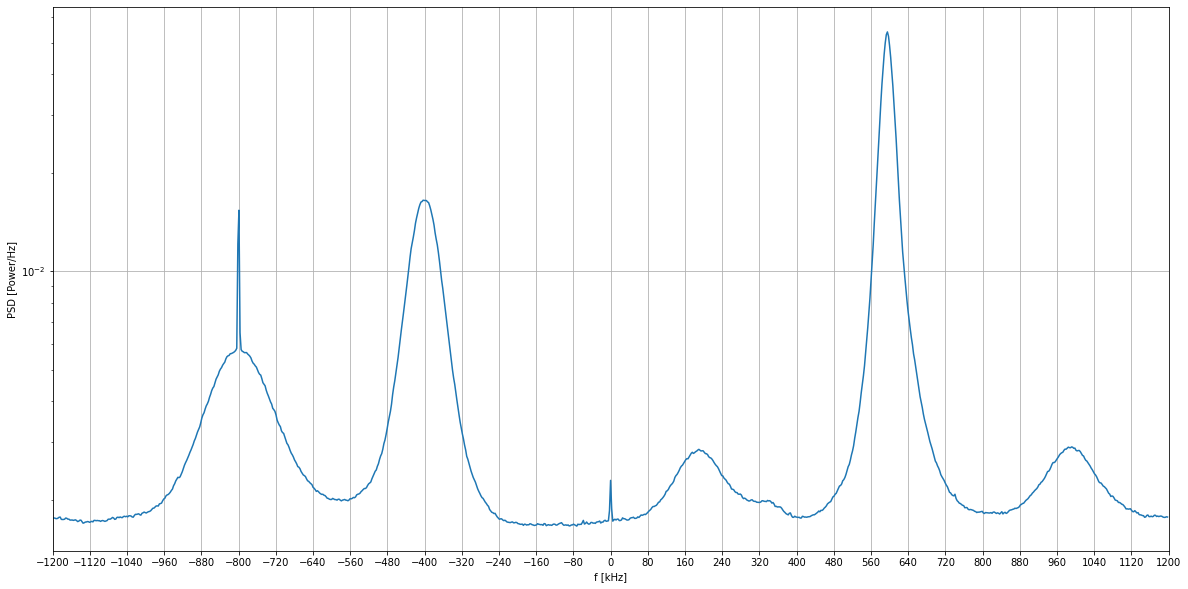

In [5]:
welch(iq_samples_below, 2400000)

In [6]:
t = np.arange(24000000)
# ot = offset tuning?
# shift by 600kHz
iq_samples_ot = np.exp(-2 * np.pi * 600000 * 1j * t / 2400000) * iq_samples_below

/home/jlanecki/miniconda3/envs/sdr/lib/python3.9/site-packages/scipy/signal/spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


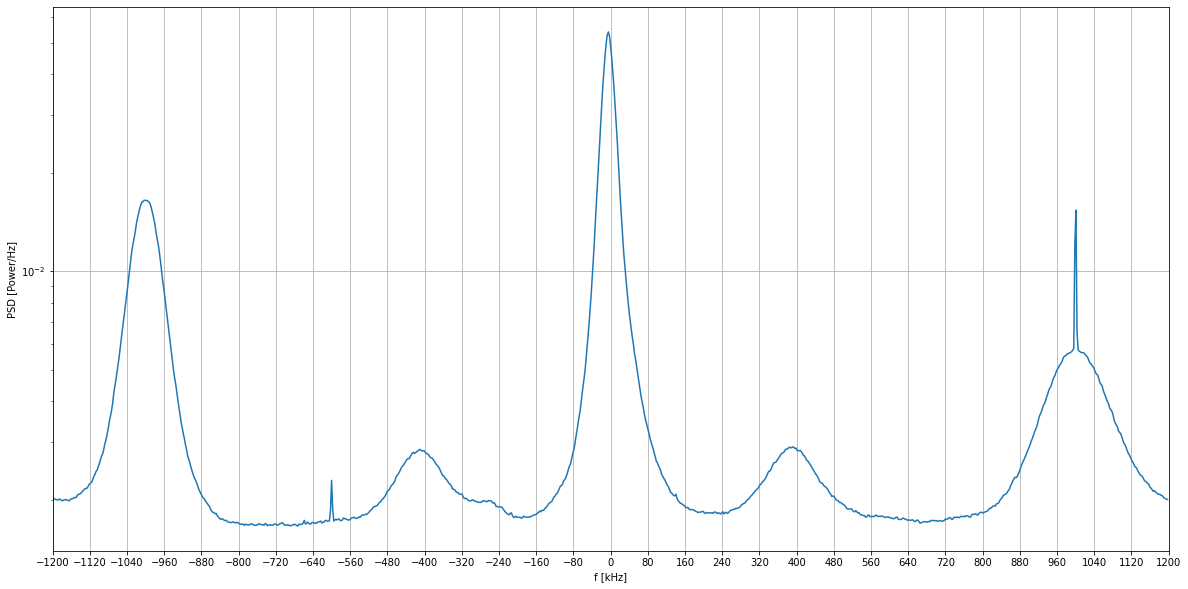

In [7]:
welch(iq_samples_ot, 2400000)

# Decimation

/home/jlanecki/miniconda3/envs/sdr/lib/python3.9/site-packages/scipy/signal/spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


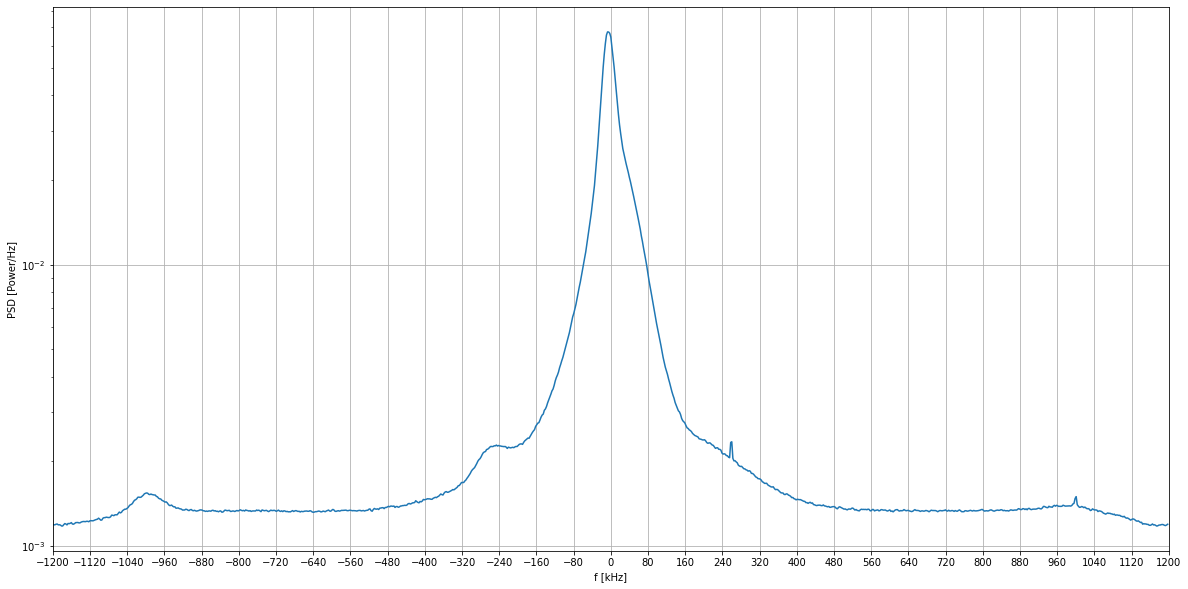

In [8]:
welch(iq_samples, 2400000)

In [9]:
dec_iq_samples = signal.decimate(iq_samples, 10)

/home/jlanecki/miniconda3/envs/sdr/lib/python3.9/site-packages/scipy/signal/spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


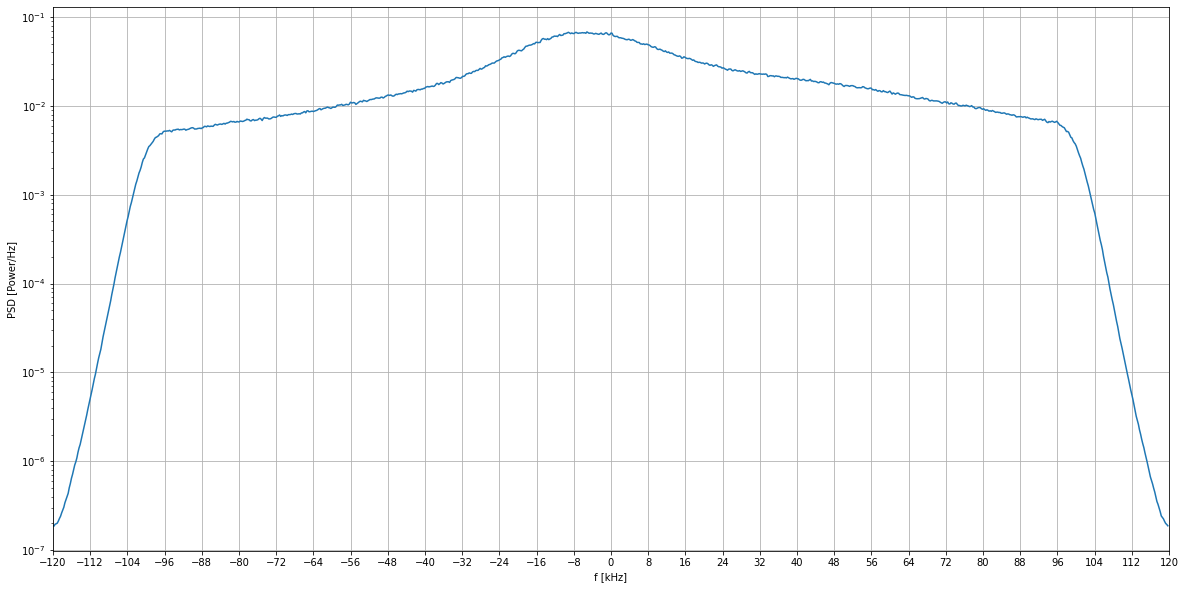

In [10]:
welch(dec_iq_samples, 240000)

In [11]:
dec_fir_iq_samples = signal.decimate(iq_samples, 10, ftype='fir')

/home/jlanecki/miniconda3/envs/sdr/lib/python3.9/site-packages/scipy/signal/spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


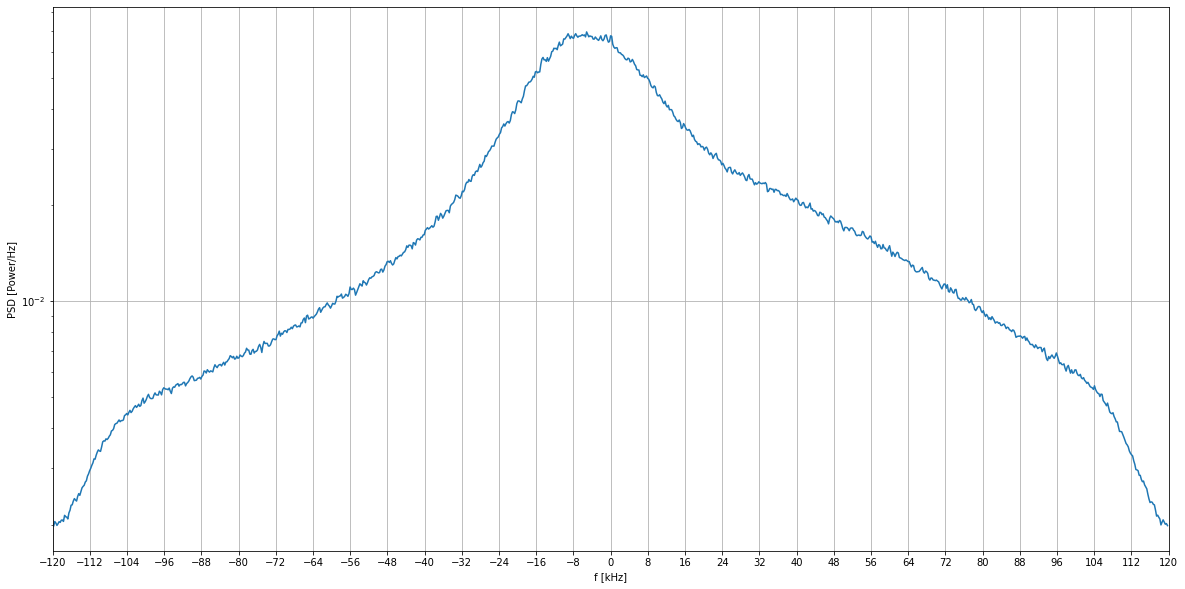

In [12]:
welch(dec_fir_iq_samples, 240000)

In [13]:
dec_iq_ot_samples = signal.decimate(iq_samples_ot, 10)

/home/jlanecki/miniconda3/envs/sdr/lib/python3.9/site-packages/scipy/signal/spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


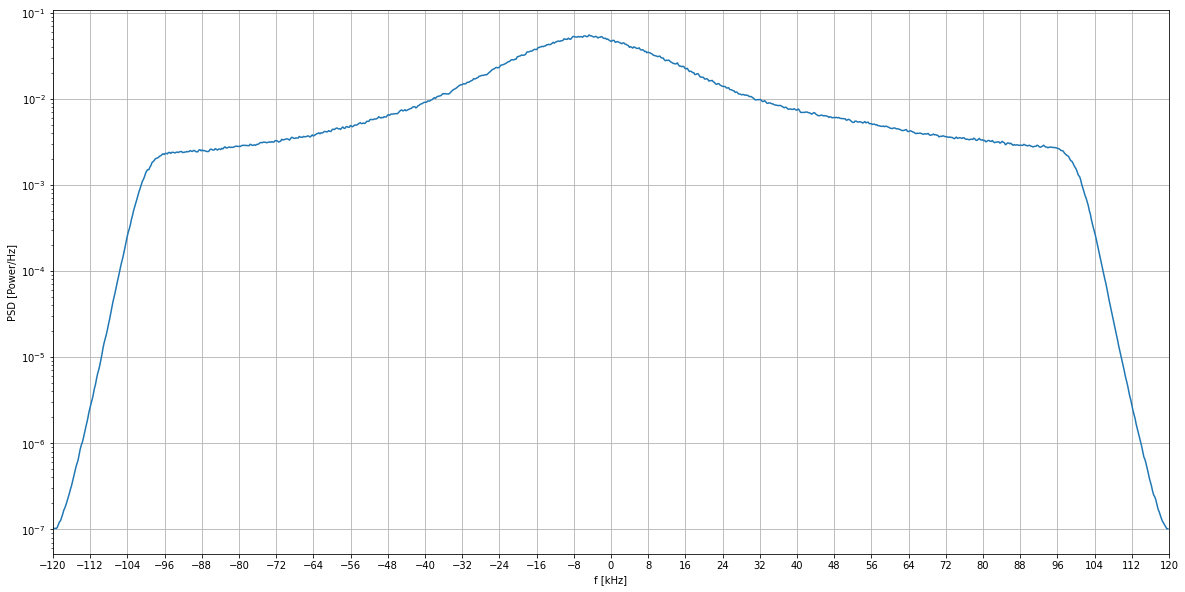

In [14]:
welch(dec_iq_ot_samples, 240000)

# Demodulation

In [15]:
demod_samples = fm_demod_1(dec_iq_samples)

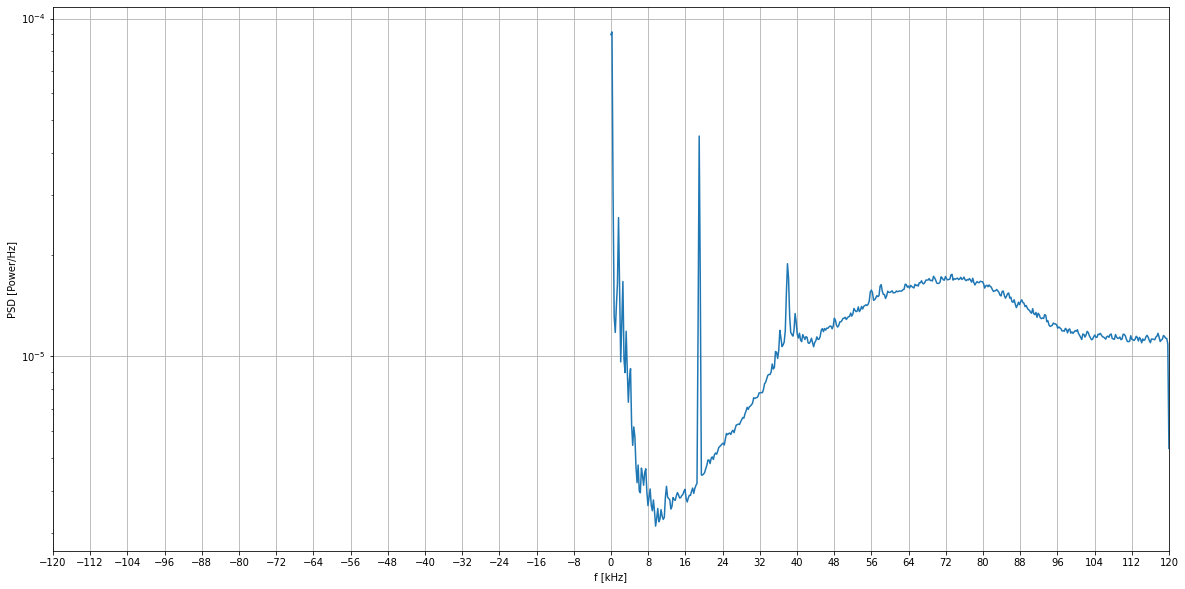

In [16]:
welch(demod_samples, 240000)

In [17]:
demod_fir_samples = fm_demod_1(dec_fir_iq_samples)

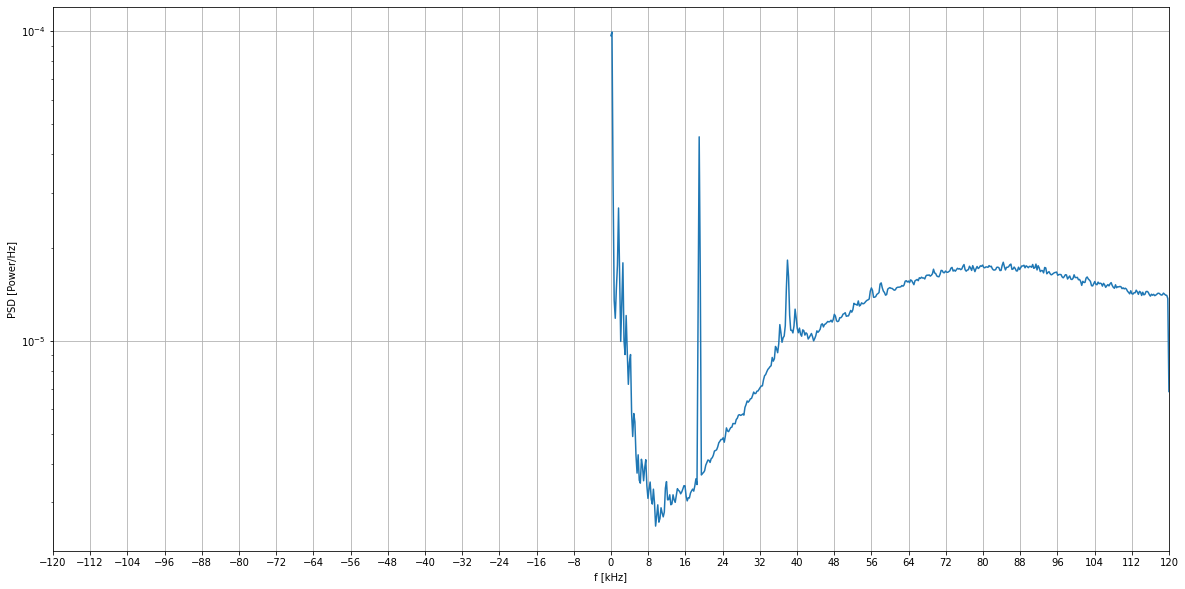

In [18]:
welch(demod_fir_samples, 240000)

In [19]:
demod_ot_samples = fm_demod_1(dec_iq_ot_samples)

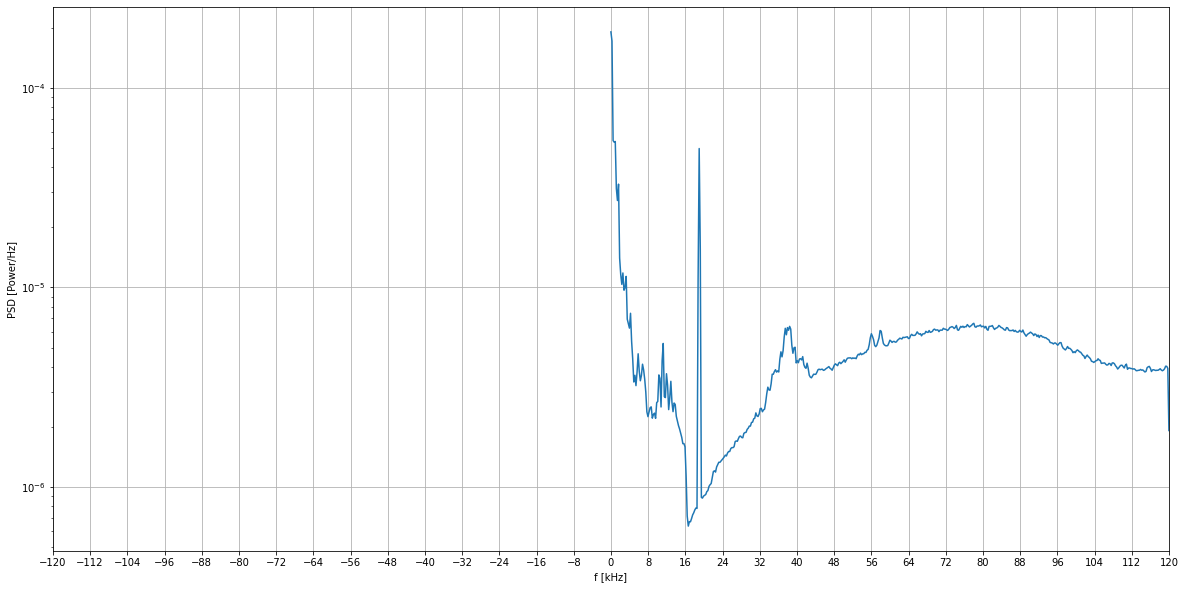

In [20]:
welch(demod_ot_samples, 240000)

# Final decimation and saving audio 

In [21]:
demod_dec_samples = signal.decimate(demod_samples, 5)
norm_demod_dec_samples = demod_dec_samples / np.abs(demod_dec_samples).max()

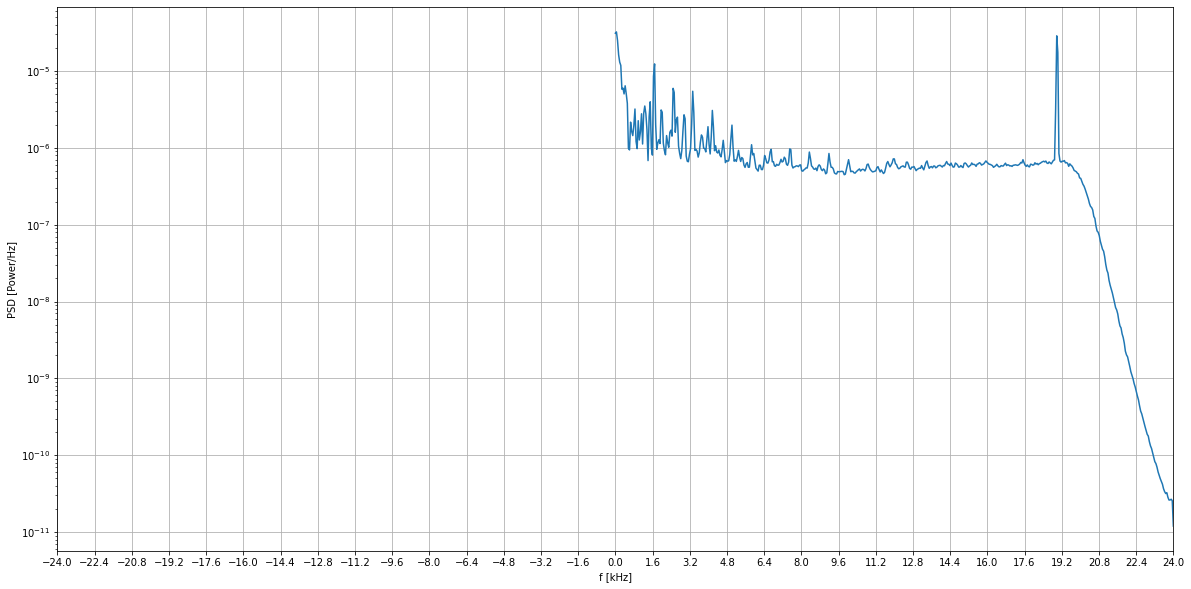

In [22]:
welch(norm_demod_dec_samples, 48000)

In [23]:
wavfile.write('audio/mono_basic.wav', 48000, norm_demod_dec_samples)

In [24]:
demod_dec_fir_samples = signal.decimate(demod_fir_samples, 5, ftype='fir')
norm_demod_dec_fir_samples = demod_dec_fir_samples / np.abs(demod_dec_fir_samples).max()

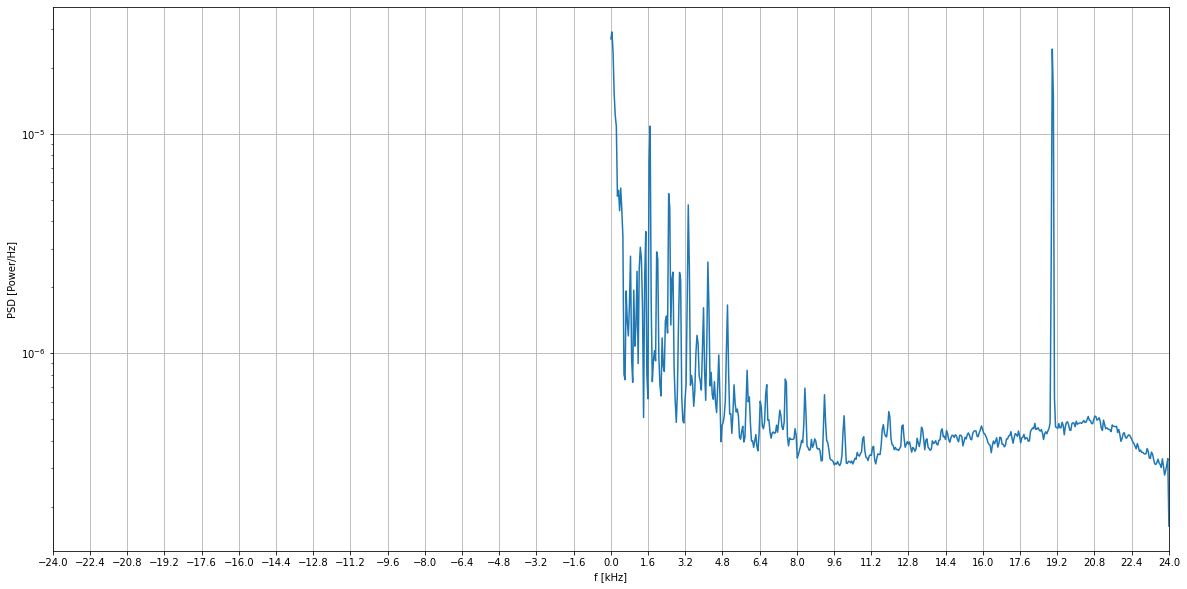

In [25]:
welch(norm_demod_dec_fir_samples, 48000)

In [26]:
wavfile.write('audio/mono_fir.wav', 48000, norm_demod_dec_fir_samples)

In [27]:
demod_dec_ot_samples = signal.decimate(demod_ot_samples, 5)
norm_demod_dec_ot_samples = demod_dec_ot_samples / np.abs(demod_dec_ot_samples).max()

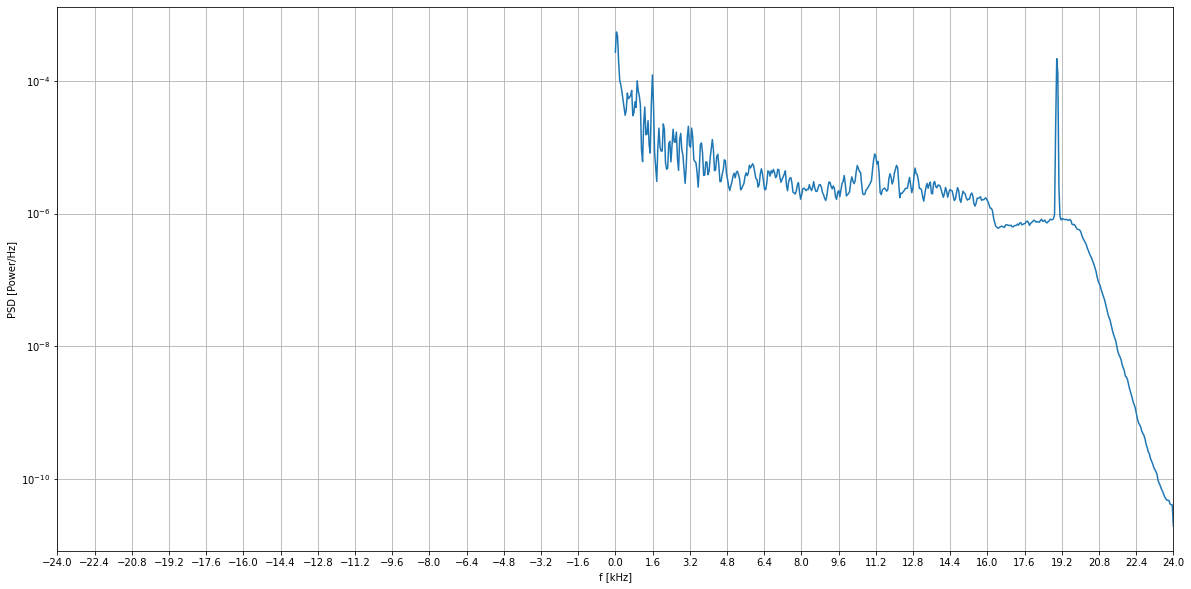

In [28]:
welch(demod_dec_ot_samples, 48000)

In [29]:
wavfile.write('audio/mono2_offset_tuned.wav', 48000, demod_dec_ot_samples)

# Stereo FM demodulation

**TODO:** 
 - deemphasis to bump higher frequencies?
 - PLL on the pilot!
 - non-offset tuned signals? (PROBABLY NOT, audio sucks)

In [30]:
t = np.arange(1, 2400000)
downmixed_demod_ot_samples = demod_ot_samples * np.cos(2 * np.pi * -38000 * t / 240000)

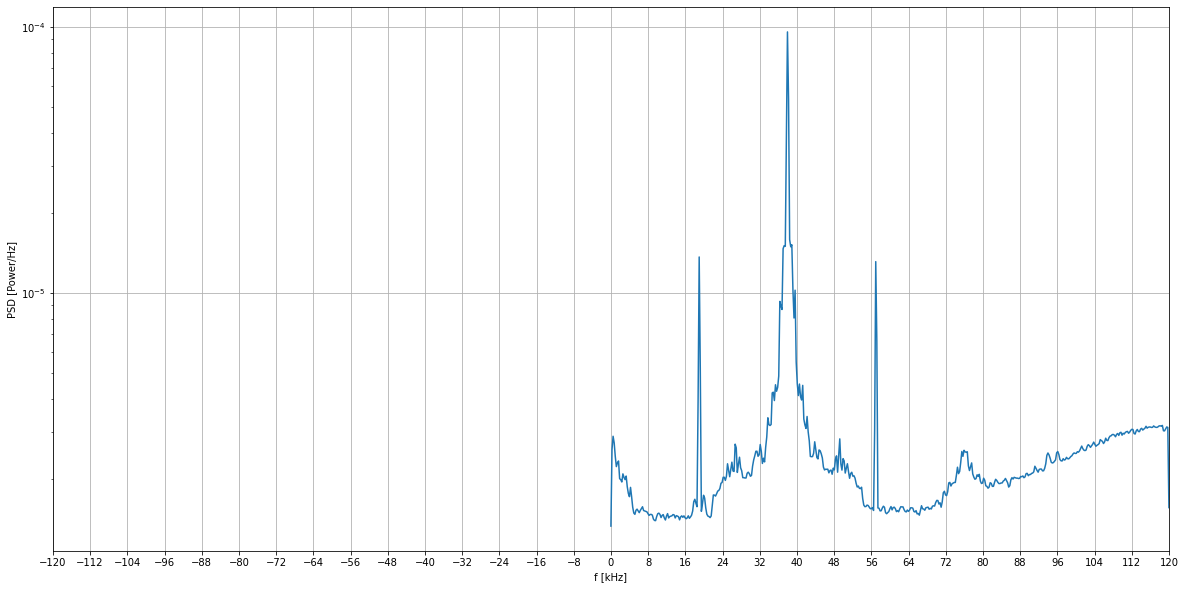

In [31]:
welch(downmixed_demod_ot_samples, 240000)

In [56]:
# assumes 16kHz cutoff, 240kHz sampling rate at this point
def lowpass(input_signal, cutoff_freq=16000):
    cutoff = cutoff_freq / (240000 * 0.5)
    b, a = butter(10, cutoff, btype='low', analog=False)
    return lfilter(b, a, input_signal)

  channel_diff_ot_samples = lowpass(downmixed_demod_ot_samples)

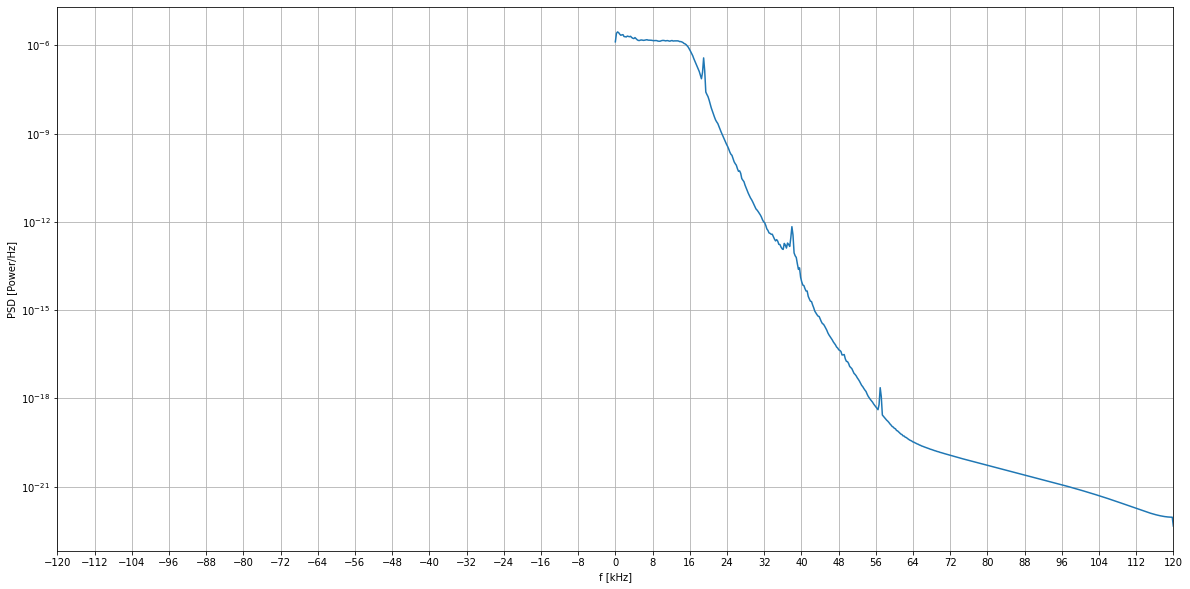

In [33]:
welch(channel_diff_ot_samples, 240000)

In [34]:
dec_channel_diff_ot_samples = signal.decimate(channel_diff_ot_samples, 5)

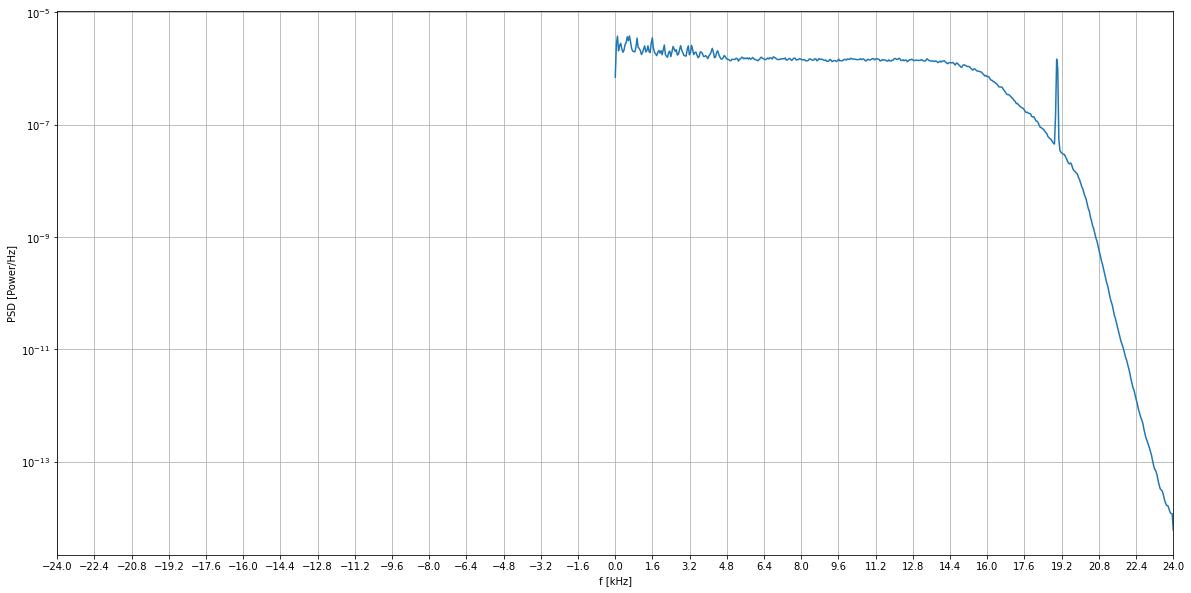

In [35]:
welch(dec_channel_diff_ot_samples, 48000)

In [36]:
left_channel = demod_dec_ot_samples + dec_channel_diff_ot_samples
right_channel = demod_dec_ot_samples - dec_channel_diff_ot_samples

norm_left_channel = left_channel / np.abs(left_channel).max()
norm_right_channel = right_channel / np.abs(right_channel).max()

In [37]:
wavfile.write('audio/stereo2_offset_tuned.wav', 48000, np.dstack([norm_left_channel, norm_right_channel])[0])

In [38]:
# just to see - turns out it's VERY noisy (low SNR prolly)
wavfile.write('audio/stereo2_offset_tuned_diff.wav', 48000, dec_channel_diff_ot_samples)

# Stereo FM - L - R demodulated from lower-sideband
Because upper-sideband contains more noise - we use phasing method.

In [82]:
downmixed_demod_ot_samples_iq = demod_ot_samples * np.exp(2 * np.pi * -38000 * 1j * t / 240000)

/home/jlanecki/miniconda3/envs/sdr/lib/python3.9/site-packages/scipy/signal/spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


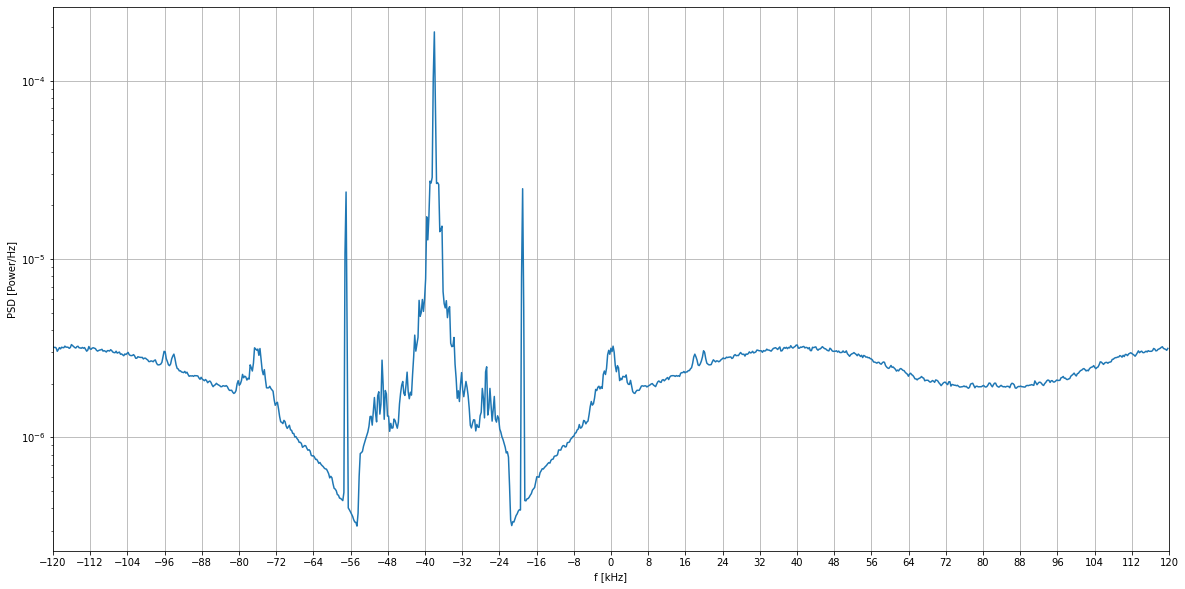

In [83]:
welch(downmixed_demod_ot_samples_iq, 240000)

In [84]:
downmixed_demod_ot_samples_i = np.real(downmixed_demod_ot_samples_iq)
downmixed_demod_ot_samples_q = np.imag(downmixed_demod_ot_samples_iq)

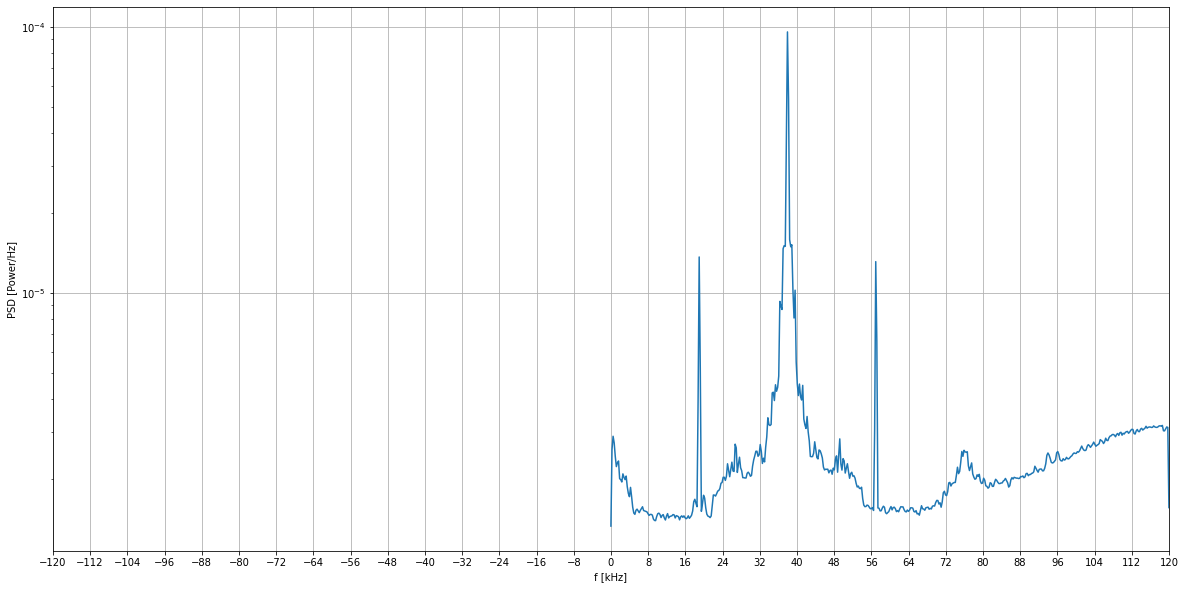

In [85]:
welch(downmixed_demod_ot_samples_i, 240000)

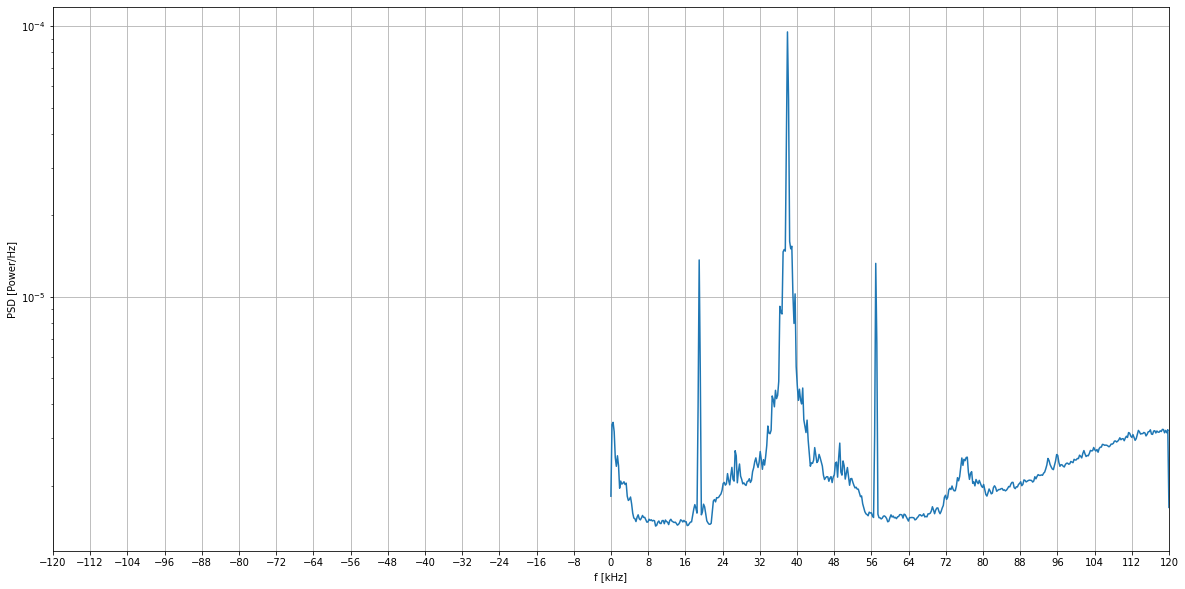

In [86]:
welch(downmixed_demod_ot_samples_q, 240000)

Magnitude spectrums are the same.

In [87]:
# we theoretically can LPF after Hilbert transform too
# because it doesn't really change frequency content of the signal
# downmixed_demod_ot_samples_q = lowpass(downmixed_demod_ot_samples_lsb)
downmixed_demod_ot_samples_q_analytical = hilbert(downmixed_demod_ot_samples_q)

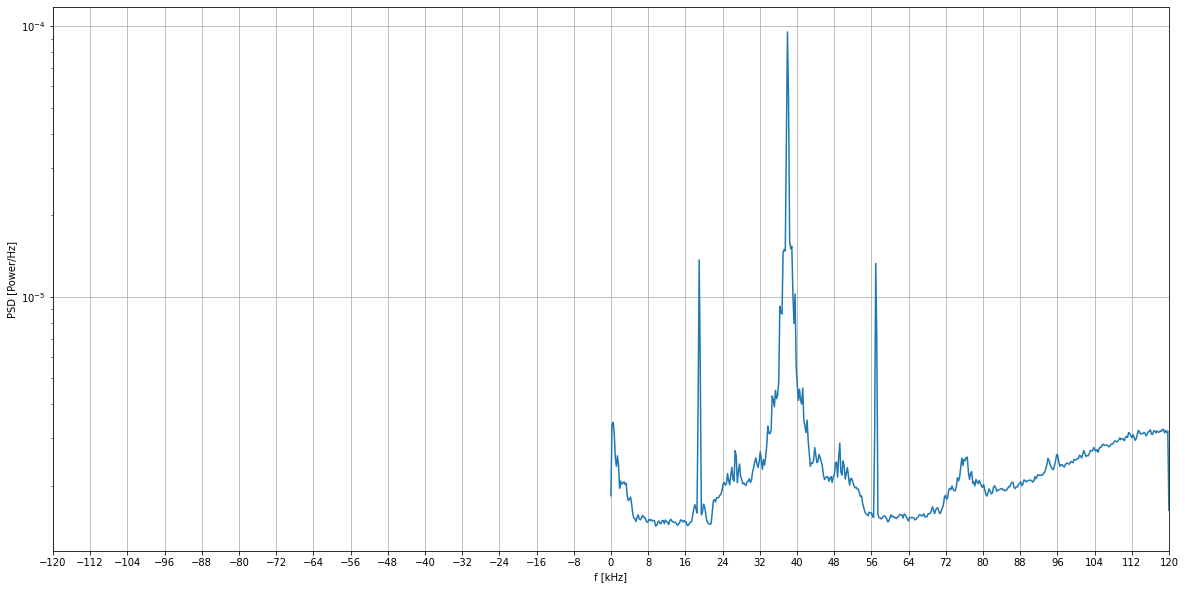

In [88]:
downmixed_demod_ot_samples_q_hilbert = np.imag(downmixed_demod_ot_samples_q_analytical)
welch(downmixed_demod_ot_samples_q_hilbert, 240000)

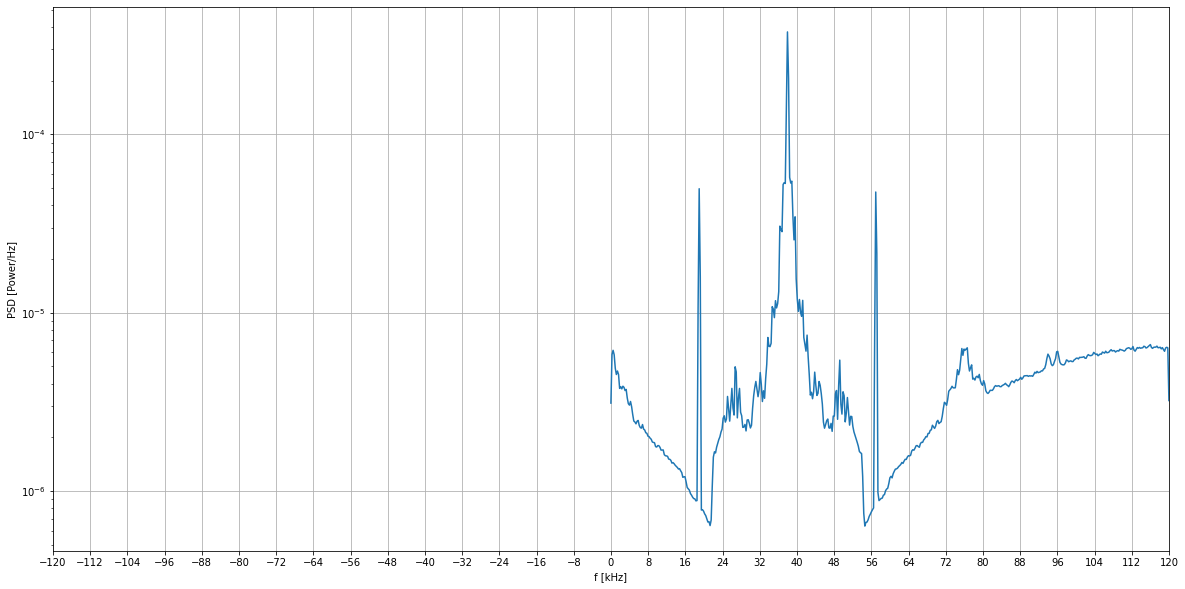

In [90]:
downmixed_demod_ot_samples_lsb = downmixed_demod_ot_samples_i + downmixed_demod_ot_samples_q_hilbert
welch(downmixed_demod_ot_samples_lsb, 240000)

In [91]:
# downmixed_demod_ot_samples_lsb = lowpass(downmixed_demod_ot_samples_lsb, 16000)
dec_channel_diff_ot_samples_lsb = signal.decimate(downmixed_demod_ot_samples_lsb, 5)

left_channel = demod_dec_ot_samples + dec_channel_diff_ot_samples_lsb
right_channel = demod_dec_ot_samples - dec_channel_diff_ot_samples_lsb

norm_left_channel = left_channel / np.abs(left_channel).max()
norm_right_channel = right_channel / np.abs(right_channel).max()

In [92]:
wavfile.write('audio/stereo2_offset_tuned_lsb.wav', 48000, np.dstack([norm_left_channel, norm_right_channel])[0])

In [93]:
wavfile.write('audio/stereo2_offset_tuned_diff_lsb.wav', 48000, dec_channel_diff_ot_samples_lsb)

### Obsevations
Quality isn't really improved.